# WER on single recording end to end

#### Common packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from graphviz import Digraph

## Split Corpus into Recordings $\langle A_i,T_i \rangle$ and Transcription Splits $\lange A_{i,j}, T_{i,j}$ within Recordings

In [15]:
from Cfg import Cfg
C = Cfg('NIST', 8000, 'amharic') 

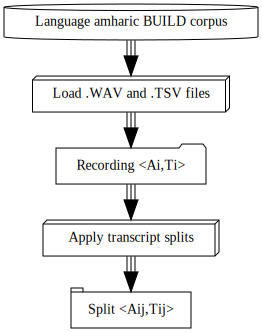

In [50]:
dot = Digraph()
dot.node(f'Language {C.language} BUILD corpus', shape='cylinder')
dot.node('Load .WAV and .TSV files', shape='box3d')
dot.edge(f'Language {C.language} BUILD corpus', 'Load .WAV and .TSV files', color="black:invis:black:invis:black", arrowsize='2')
dot.node('Recording <Ai,Ti>', shape='folder')
dot.edge('Load .WAV and .TSV files', 'Recording <Ai,Ti>', color="black:invis:black:invis:black", arrowsize='2')
dot.node('Apply transcript splits', shape='box3d')
dot.edge('Recording <Ai,Ti>', 'Apply transcript splits', color="black:invis:black:invis:black", arrowsize='2')
dot.node('Split <Aij,Tij>', shape='tab')
dot.edge('Apply transcript splits', 'Split <Aij,Tij>', color="black:invis:black:invis:black", arrowsize='2')
dot

In [4]:
from RecordingCorpus import RecordingCorpus
from multiprocessing import Pool
if __name__ == '__main__':
    with Pool(16) as pool:
        recordings = RecordingCorpus(C, pool)

100%|██████████| 122/122 [00:02<00:00, 40.89it/s]


In [5]:
from SplitCorpus import SplitCorpus
splits=SplitCorpus.from_recordings(C, recordings)

## Subsplit $A_{i,j}$ on silence and apportion text to trimmed chunks by word sizes in $T_{i,j} = \langle w_{i,j,k} \rangle$ where $w_{i,j,k}=\langle g_{i,j,k,l} \rangle$

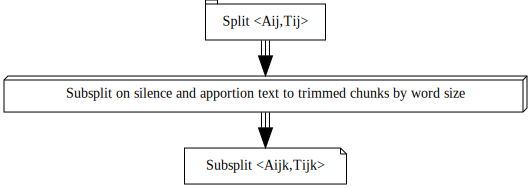

In [55]:
dot = Digraph()
dot.node('Split <Aij,Tij>', shape='tab')
dot.node('Subsplit on silence and apportion text to trimmed chunks by word size', shape='box3d')
dot.node('Subsplit <Aijk,Tijk>', shape='note')
dot.edge('Split <Aij,Tij>', 'Subsplit on silence and apportion text to trimmed chunks by word size',color="black:invis:black:invis:black", arrowsize='2')
dot.edge('Subsplit on silence and apportion text to trimmed chunks by word size', 'Subsplit <Aijk,Tijk>', color="black:invis:black:invis:black", arrowsize='2')
dot

In [48]:
from SubSplitCorpus import SubSplitCorpus

In [49]:
import pickle
with open('bfgpu.pkl', 'rb') as f:
    subsplits=pickle.load(f)

# Train ASR NN on subsplits $A_{i,j,k} \to P_{i,j,k} \approx T_{i,j,k}$

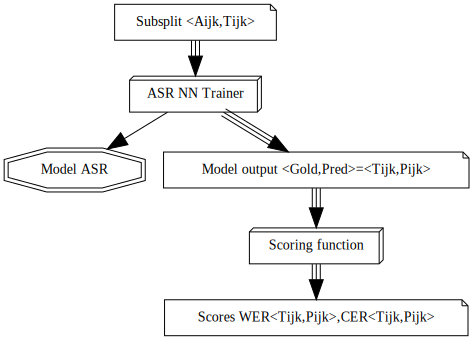

In [90]:
dot = Digraph()
dot.node('Subsplit <Aijk,Tijk>', shape='note')
dot.node('ASR NN Trainer', shape='box3d')
dot.edge('Subsplit <Aijk,Tijk>', 'ASR NN Trainer',color="black:invis:black:invis:black", arrowsize='2')
dot.node('Model ASR',shape='doubleoctagon')
dot.edge('ASR NN Trainer', 'Model ASR',color="black", arrowsize='2')
dot.node('Model output <Gold,Pred>=<Tijk,Pijk>', shape='note')
dot.edge('ASR NN Trainer','Model output <Gold,Pred>=<Tijk,Pijk>',color="black:invis:black:invis:black", arrowsize='2')
dot.node('Scoring function',shape='box3d')
dot.edge('Model output <Gold,Pred>=<Tijk,Pijk>','Scoring function',color="black:invis:black:invis:black", arrowsize='2')
dot.node('Scores WER<Tijk,Pijk>,CER<Tijk,Pijk>', shape='note')
dot.edge('Scoring function','Scores WER<Tijk,Pijk>,CER<Tijk,Pijk>',color="black:invis:black:invis:black", arrowsize='2')
dot

## Concatenate $P_{i,j,k}$ giving $P_{i,j} = P_{i,j,1}\|\cdots\|P_{i,j,-1}$

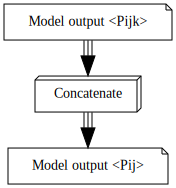

In [91]:
dot = Digraph()
dot.node('Model output <Pijk>', shape='note')
dot.node('Concatenate',shape='box3d')
dot.node('Model output <Pij>', shape='note')
dot.edge('Model output <Pijk>','Concatenate',color="black:invis:black:invis:black", arrowsize='2')
dot.edge('Concatenate','Model output <Pij>',color="black:invis:black:invis:black", arrowsize='2')
dot


## Train text-to-text corrector on both $P_{i,j,k} \to Q_{i,j,k} \approx T_{i,j,k}$ and $P_{i,j} \to Q_{i,j} \approx T_{i,j}$ and score

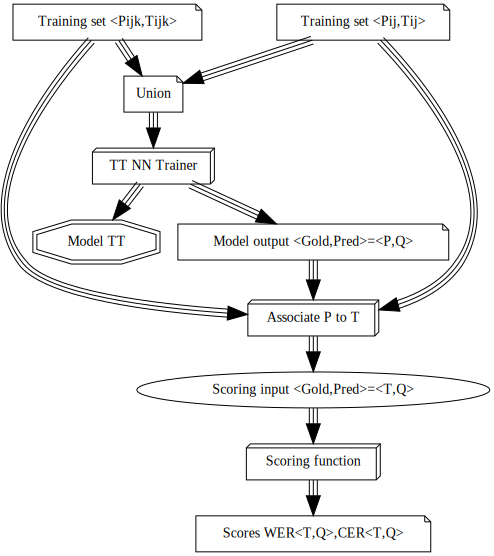

In [93]:
dot = Digraph()
dot.node('Training set <Pijk,Tijk>', shape='note')
dot.node('Training set <Pij,Tij>', shape='note')
dot.node('Union', shape='note')
dot.node('TT NN Trainer', shape='box3d')
dot.node('Model TT',shape='doubleoctagon')
dot.node('Model output <Gold,Pred>=<P,Q>', shape='note')
dot.node('Associate P to T', shape='box3d')
dot.node('Scoring input <Gold,Pred>=<T,Q>')
dot.node('Scoring function',shape='box3d')
dot.node('Scores WER<T,Q>,CER<T,Q>', shape='note')
for x,y in [('Training set <Pijk,Tijk>', 'Union'),
            ('Training set <Pij,Tij>', 'Union'),
            ('Union','TT NN Trainer'),
            ('TT NN Trainer','Model TT'),
            ('TT NN Trainer','Model output <Gold,Pred>=<P,Q>'),
            ('Model output <Gold,Pred>=<P,Q>','Associate P to T'),
            ('Training set <Pijk,Tijk>', 'Associate P to T'),
            ('Training set <Pij,Tij>', 'Associate P to T'),
            ('Associate P to T','Scoring input <Gold,Pred>=<T,Q>'),
            ('Scoring input <Gold,Pred>=<T,Q>','Scoring function'),
            ('Scoring function','Scores WER<T,Q>,CER<T,Q>')]:
    dot.edge(x,y,color="black:invis:black:invis:black", arrowsize='2')
dot

## Subsplit $A_{i,j}$ on silence alone retaining timecode $(s_{i,j,k},e_{i,j,k})$ giving $A_{i,j} = \langle (\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \rangle$ so that $\alpha_{i,j,k} = A_{i,j}[s_{i,j,k}:e_{i,j,k}]$

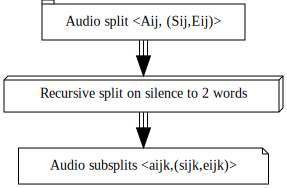

In [97]:
dot = Digraph()
dot.node('Audio split <Aij, (Sij,Eij)>', shape='tab')
dot.node('Recursive split on silence to 2 words', shape='box3d')
dot.node('Audio subsplits <aijk,(sijk,eijk)>', shape='note')
dot.edge('Audio split <Aij, (Sij,Eij)>', 'Recursive split on silence to 2 words', color="black:invis:black:invis:black", arrowsize='2')
dot.edge('Recursive split on silence to 2 words','Audio subsplits <aijk,(sijk,eijk)>', color="black:invis:black:invis:black", arrowsize='2')
dot

## Infer $(\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \xrightarrow{ASR} p_{i,j,k} $

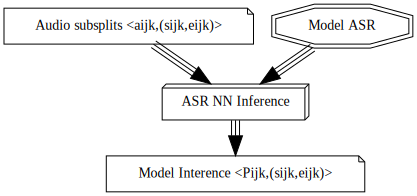

In [118]:
dot = Digraph()
dot.node('Audio subsplits <aijk,(sijk,eijk)>', shape='note')
dot.node('Model ASR',shape='doubleoctagon')
dot.node('ASR NN Inference', shape='box3d')
dot.node('Model Interence <Pijk,(sijk,eijk)>', shape='note')
for x,y in [('Audio subsplits <aijk,(sijk,eijk)>', 'ASR NN Inference'),
        ('Model ASR', 'ASR NN Inference'),
        ('ASR NN Inference', 'Model Interence <Pijk,(sijk,eijk)>')]:
    dot.edge(x,y,color="black:invis:black:invis:black", arrowsize='2')
dot

## Concatenate $p_{i,j,k} \to p_{i,j}$

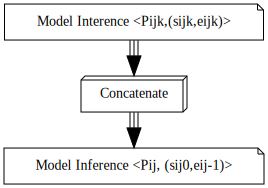

In [119]:
dot = Digraph()
dot.node('Model Interence <Pijk,(sijk,eijk)>', shape='note')
dot.node('Concatenate', shape='box3d')
dot.node('Model Inference <Pij, (sij0,eij-1)>', shape='note')
for x,y in [('Model Interence <Pijk,(sijk,eijk)>', 'Concatenate'),
        ('Concatenate', 'Model Inference <Pij, (sij0,eij-1)>')]:
    dot.edge(x,y,color="black:invis:black:invis:black", arrowsize='2')
dot

## Infer $p_{i,j} \xrightarrow{TT} (q_{i,j},(s_{i,j,0},e_{i,j,-1}))$ 

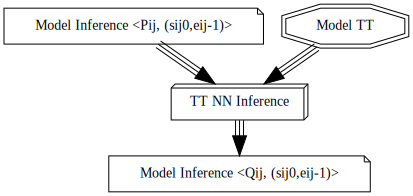

In [123]:
dot = Digraph()
dot.node('Model Inference <Pij, (sij0,eij-1)>', shape='note')
dot.node('Model TT',shape='doubleoctagon')
dot.node('TT NN Inference', shape='box3d')
dot.node('Model Inference <Qij, (sij0,eij-1)>', shape='note')
for x,y in [('Model Inference <Pij, (sij0,eij-1)>', 'TT NN Inference'),
            ('Model TT', 'TT NN Inference'),
            ('TT NN Inference', 'Model Inference <Qij, (sij0,eij-1)>')]:
    dot.edge(x,y,color="black:invis:black:invis:black", arrowsize='2')
dot

## Concatenate $\langle \langle (q_{i,j,k},(s_{i,j,k},e_{i,j,k})) \rangle \rangle $ giving transcript $Q_i = \langle (q_{i,j}, (s_{i,j,0},e_{i,j,-1})) \rangle$

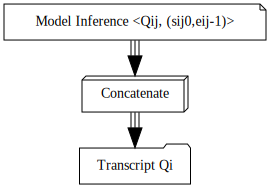

In [126]:
dot = Digraph()
dot.node('Model Inference <Qij, (sij0,eij-1)>', shape='note')
dot.node('Concatenate',shape='box3d'),
dot.node('Transcript Qi', shape='folder')
for x,y in [('Model Inference <Qij, (sij0,eij-1)>', 'Concatenate'),
            ('Concatenate', 'Transcript Qi')]:
    dot.edge(x,y,color="black:invis:black:invis:black", arrowsize='2')
dot

## Save transcript $\Theta_i$ in .CTM format

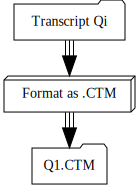

In [130]:
dot = Digraph()
dot.node('Transcript Qi', shape='folder')
dot.node('Format as .CTM',shape='box3d'),
dot.node('Q1.CTM', shape='folder')
for x,y in [('Transcript Qi', 'Format as .CTM'),
            ('Format as .CTM', 'Q1.CTM')]:
    dot.edge(x,y,color="black:invis:black:invis:black", arrowsize='2')
dot

## Score $\langle T_i,Q_i\rangle$ using `sclite` individually

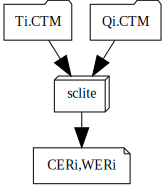

In [135]:
dot = Digraph()
dot.node('Ti.CTM', shape='folder')
dot.node('Qi.CTM', shape='folder')
dot.node('sclite', shape='box3d')
dot.node('CERi,WERi', shape='note')
for x,y in [('Ti.CTM', 'sclite'),
            ('Qi.CTM', 'sclite'),
            ('sclite', 'CERi,WERi')]:
    dot.edge(x,y,color="black", arrowsize='2')
dot

## Score $\langle T_i,\Theta_i\rangle$ using `sclite` collectively

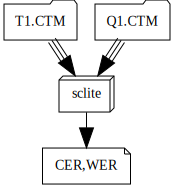

In [139]:
dot = Digraph()
dot.node('<T1.CTM>', shape='folder')
dot.node('<Q1.CTM>', shape='folder')
dot.node('sclite', shape='box3d')
dot.node('CER,WER', shape='note')
dot.edge('sclite','CER,WER',color="blackblack", arrowsize='2')
for x,y in [('<T1.CTM>', 'sclite'),
            ('<Q1.CTM>', 'sclite')]:
    dot.edge(x,y,color="black:invis:black:invis:black", arrowsize='2')
dot